# Station Matching

The goal of this notebook is to identify stations that changed IDs. The IDs fo these pairs of matching stations will be stored in a csv, which then be fed into concentation as a lookup table. Pairs will receive unique flags, with the older station receiving a different flag than the newer station.


## Environment set-up

In [2]:
from shapely.geometry import Point
from shapely.ops import nearest_points

from functools import reduce
import datetime
from pandas import *
import boto3
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from io import BytesIO, StringIO

import tempfile  # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket

import s3fs

# import tempfile  # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket
import os

# Silence warnings
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(
    "ignore", category=ShapelyDeprecationWarning
)  # Warning is raised when creating Point object from coords. Can't figure out why.

plt.rcParams["figure.dpi"] = 300

In [3]:
# AWS credentials
s3 = s3fs.S3FileSystem #must be set to this to use such commands as ls
#s3 = boto3.resource('s3')
s3_client = boto3.client('s3')

## AWS buckets
bucket = "wecc-historical-wx"
qaqcdir = "3_qaqc_wx/VALLEYWATER/"
mergedir = "4_merge_wx/VALLEYWATER/"

In [4]:
# Define temporary directory in local drive for downloading data from S3 bucket
# If the directory doesn't exist, it will be created
# If we used zarr, this wouldn't be neccessary
temp_dir = "./tmp"
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)

In [5]:
def read_nc_from_s3_clean(network_name, station_id, temp_dir):
    """Read netcdf file containing station data for a single station of interest from AWS s3 bucket

    Parameters
    ----------
    network_name: str
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")

    Returns
    -------
    station_data: xr.Dataset

    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file
    I'd like to see us use a zarr workflow if possible to avoid this.

    """

    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir=temp_dir, prefix="", suffix=".nc", delete=True
    )

    # Create s3 file system
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    s3_url = "s3://wecc-historical-wx/2_clean_wx/{}/{}.nc".format(
        network_name, station_id
    )

    # Read in the data using xarray
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine="h5netcdf").load()

    # Close temporary file
    temp_file.close()

    return station_data

In [6]:
def read_zarr_from_s3(station_id, temp_dir):
    """Read zarr file containing station data for a single station of interest from AWS s3 bucket

    Parameters
    ----------
    network_name: str
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")

    Returns
    -------
    station_data: xr.Dataset

    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file
    """

    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir=temp_dir, prefix="", suffix=".zarr", delete=True
    )

    # Create s3 file system
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    s3_url = "s3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_{}.zarr".format(
        station_id
    )
    print(s3_url)

    # Read in the data using xarray
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine="zarr").load()

    # Close temporary file
    temp_file.close()

    return station_data

In [7]:
def qaqc_ds_to_df(ds, verbose=False):
    """Converts xarray ds for a station to pandas df in the format needed for the pipeline

    Parameters
    ----------
    ds : xr.Dataset
        input data from the clean step
    verbose : bool, optional
        if True, provides runtime output to the terminal

    Returns
    -------
    df : pd.DataFrame
        converted xr.Dataset into dataframe
    MultiIndex : pd.Index
        multi-index of station and time
    attrs : list of str
        attributes from xr.Dataset
    var_attrs : list of str
        variable attributes from xr.Dataset
    era_qc_vars : list of str
        QAQC variables

    Notes
    -----
    This is the notebook friendly version (no logger statements).
    """
    ## Add qc_flag variable for all variables, including elevation;
    ## defaulting to nan for fill value that will be replaced with qc flag

    for key, val in ds.variables.items():
        if val.dtype == object:
            if key == "station":
                if str in [type(v) for v in ds[key].values]:
                    ds[key] = ds[key].astype(str)
            else:
                if str in [type(v) for v in ds.isel(station=0)[key].values]:
                    ds[key] = ds[key].astype(str)

    exclude_qaqc = [
        "time",
        "station",
        "lat",
        "lon",
        "qaqc_process",
        "sfcWind_method",
        "pr_duration",
        "pr_depth",
        "PREC_flag",
        "rsds_duration",
        "rsds_flag",
        "anemometer_height_m",
        "thermometer_height_m",
    ]  # lat, lon have different qc check

    raw_qc_vars = []  # qc_variable for each data variable, will vary station to station
    era_qc_vars = []  # our ERA qc variable
    old_era_qc_vars = []  # our ERA qc variable

    for var in ds.data_vars:
        if "q_code" in var:
            raw_qc_vars.append(
                var
            )  # raw qc variable, need to keep for comparison, then drop
        if "_qc" in var:
            raw_qc_vars.append(
                var
            )  # raw qc variables, need to keep for comparison, then drop
        if "_eraqc" in var:
            era_qc_vars.append(
                var
            )  # raw qc variables, need to keep for comparison, then drop
            old_era_qc_vars.append(var)

    print(f"era_qc existing variables:\n{era_qc_vars}")
    n_qc = len(era_qc_vars)

    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars and "_eraqc" not in var:
            qc_var = var + "_eraqc"  # variable/column label

            # if qaqc var does not exist, adds new variable in shape of original variable with designated nan fill value
            if qc_var not in era_qc_vars:
                print(f"nans created for {qc_var}")
                ds = ds.assign({qc_var: xr.ones_like(ds[var]) * np.nan})
                era_qc_vars.append(qc_var)

    print("{} created era_qc variables".format(len(era_qc_vars) - len(old_era_qc_vars)))
    if len(era_qc_vars) != n_qc:
        print("{}".format(np.setdiff1d(old_era_qc_vars, era_qc_vars)))

    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    # var_attrs = {var: ds[var].attrs for var in list(ds.data_vars.keys())}

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        df = ds.to_dataframe()

    # instrumentation heights
    if "anemometer_height_m" not in df.columns:
        try:
            df["anemometer_height_m"] = (
                np.ones(ds["time"].shape) * ds.anemometer_height_m
            )
        except:
            print("Filling anemometer_height_m with NaN.", flush=True)
            df["anemometer_height_m"] = np.ones(len(df)) * np.nan
        finally:
            pass
    if "thermometer_height_m" not in df.columns:
        try:
            df["thermometer_height_m"] = (
                np.ones(ds["time"].shape) * ds.thermometer_height_m
            )
        except:
            print("Filling thermometer_height_m with NaN.", flush=True)
            df["thermometer_height_m"] = np.ones(len(df)) * np.nan
        finally:
            pass

    # De-duplicate time axis
    df = df[~df.index.duplicated()].sort_index()

    # Save station/time multiindex
    MultiIndex = df.index
    station = df.index.get_level_values(0)
    df["station"] = station

    # Station pd.Series to str
    station = station.unique().values[0]

    # Convert time/station index to columns and reset index
    df = df.droplevel(0).reset_index()

    # Add time variables needed by multiple functions
    df["hour"] = pd.to_datetime(df["time"]).dt.hour
    df["day"] = pd.to_datetime(df["time"]).dt.day
    df["month"] = pd.to_datetime(df["time"]).dt.month
    df["year"] = pd.to_datetime(df["time"]).dt.year
    df["date"] = pd.to_datetime(df["time"]).dt.date

    return df  # , MultiIndex, attrs, var_attrs, era_qc_vars

## Step 1: Load station list

In [9]:
### Read in ASOSAWOS stations

s3_cl = boto3.client("s3")  # for lower-level processes

asosawos = s3_cl.get_object(
    Bucket="wecc-historical-wx", Key="2_clean_wx/ASOSAWOS/stationlist_ASOSAWOS_cleaned.csv"
)
asosawos_list = pd.read_csv(BytesIO(asosawos["Body"].read()))

## Step 2: Identify repeat ICAO values

In [13]:
repeat_list = asosawos_list[asosawos_list.duplicated(subset=['ICAO'], keep=False)] # 102 identical ICAOs

# how many unique ICAO duplicates are there?
print(len(repeat_list['ICAO'].unique()))

print(repeat_list.groupby('ICAO').count().max())

46
ERA-ID              6
USAF                6
WBAN                6
STATION NAME        6
CTRY                6
                   ..
sfcWind_dir         6
sfcWind_dir_nobs    6
rsds                6
rsds_nobs           6
total_nobs          6
Length: 67, dtype: int64


In [14]:
print(len(repeat_list['ICAO'].unique()))

46


### Investigate problem station KMLF

In [15]:
kmlf = repeat_list[repeat_list['ICAO']=='KMLF']

In [16]:
kmlf[['STATION NAME','LAT','LON','start_time','end_time']]

,STATION NAME,LAT,LON,start_time,end_time
61,MILFORD MUNICIPAL AP,38.417,-113.017,1948-07-23,1996-12-31
154,MILFORD MUNICIPAL AP,38.417,-113.017,1977-01-01,1983-04-30
166,MILFORD MUNICIPAL AP,38.417,-113.017,1983-05-01,1985-05-31
170,MILFORD MUNICIPAL AP,38.417,-113.017,1985-06-01,1989-05-01
185,MILFORD MUNI BRISCOE,38.417,-113.017,1997-01-01,2022-12-31
226,MILFORD MUNICIPAL AIRPORT,38.423,-113.011,2005-01-01,2022-12-31


## Step 3: Filter out duplicates

In [123]:
repeat_list_subset = repeat_list[['ICAO','ERA-ID','STATION NAME','start_time','end_time']]

In [ ]:
# check for presence of start and end times

time_check = repeat_list_subset.groupby('ICAO').apply(lambda x: x.isnull().any())

print('number of null start times:')
print(time_check['start_time'].sum())

print('number of null end times:')
print(time_check['end_time'].sum())


number of null start times:
0
number of null end times:
0


In [96]:
# check if the start and end times are identical

start_duplicate_check = repeat_list_subset.groupby('ICAO').apply(lambda x: x.duplicated(subset=['start_time'])).rename('check').reset_index()
end_duplicate_check = repeat_list_subset.groupby('ICAO').apply(lambda x: x.duplicated(subset=['end_time'])).rename('check').reset_index()


In [109]:
end_list = end_duplicate_check[end_duplicate_check['check']==True]['ICAO'].tolist()
start_list = start_duplicate_check[start_duplicate_check['check']==True]['ICAO'].tolist()

print(end_list)
print(start_list)

['KBOK', 'KMLF']
['K20V']


In [124]:
# what is going on with the stations that have duplicate start and end times? are they true duplicates?

repeat_list_subset[repeat_list_subset['ICAO'].isin(start_list + end_list)]

,ICAO,ERA-ID,STATION NAME,start_time,end_time
61,KMLF,ASOSAWOS_99999923176,MILFORD MUNICIPAL AP,1948-07-23,1996-12-31
154,KMLF,ASOSAWOS_72475723176,MILFORD MUNICIPAL AP,1977-01-01,1983-04-30
157,KBOK,ASOSAWOS_72598524267,BROOKINGS,1977-02-25,2022-12-31
166,KMLF,ASOSAWOS_74520023176,MILFORD MUNICIPAL AP,1983-05-01,1985-05-31
170,KMLF,ASOSAWOS_74520123176,MILFORD MUNICIPAL AP,1985-06-01,1989-05-01
185,KMLF,ASOSAWOS_72479723176,MILFORD MUNI BRISCOE,1997-01-01,2022-12-31
226,KMLF,ASOSAWOS_72475023176,MILFORD MUNICIPAL AIRPORT,2005-01-01,2022-12-31
239,KBOK,ASOSAWOS_72036524267,BROOKINGS AIRPORT,2005-08-02,2022-12-31
286,K20V,ASOSAWOS_72026294076,MC ELROY AFLD,2006-01-01,2013-04-30
326,K20V,ASOSAWOS_A0000594076,MC ELORY AIRFIELD AIRPORT,2006-01-01,2022-12-31


In [114]:
# load in single dc file from AWS
ds_1 = read_nc_from_s3_clean('ASOSAWOS', 'ASOSAWOS_72026294076', temp_dir) 
ds_2 = read_nc_from_s3_clean('ASOSAWOS', 'ASOSAWOS_A0000594076', temp_dir) 


#convert to formatted pandas dataframe
df_1 = qaqc_ds_to_df(ds_1, verbose=False)
df_2 = qaqc_ds_to_df(ds_2, verbose=False)

era_qc existing variables:
[]
nans created for ps_eraqc
nans created for tas_eraqc
nans created for tdps_eraqc
nans created for pr_eraqc
nans created for sfcWind_eraqc
nans created for sfcWind_dir_eraqc
nans created for elevation_eraqc
nans created for ps_altimeter_eraqc
8 created era_qc variables
[]
era_qc existing variables:
[]
nans created for ps_eraqc
nans created for tas_eraqc
nans created for tdps_eraqc
nans created for pr_eraqc
nans created for sfcWind_eraqc
nans created for sfcWind_dir_eraqc
nans created for elevation_eraqc
nans created for ps_altimeter_eraqc
8 created era_qc variables
[]


Text(0.5, 1.0, '<built-in function id>  (-106.366, 40.051)')

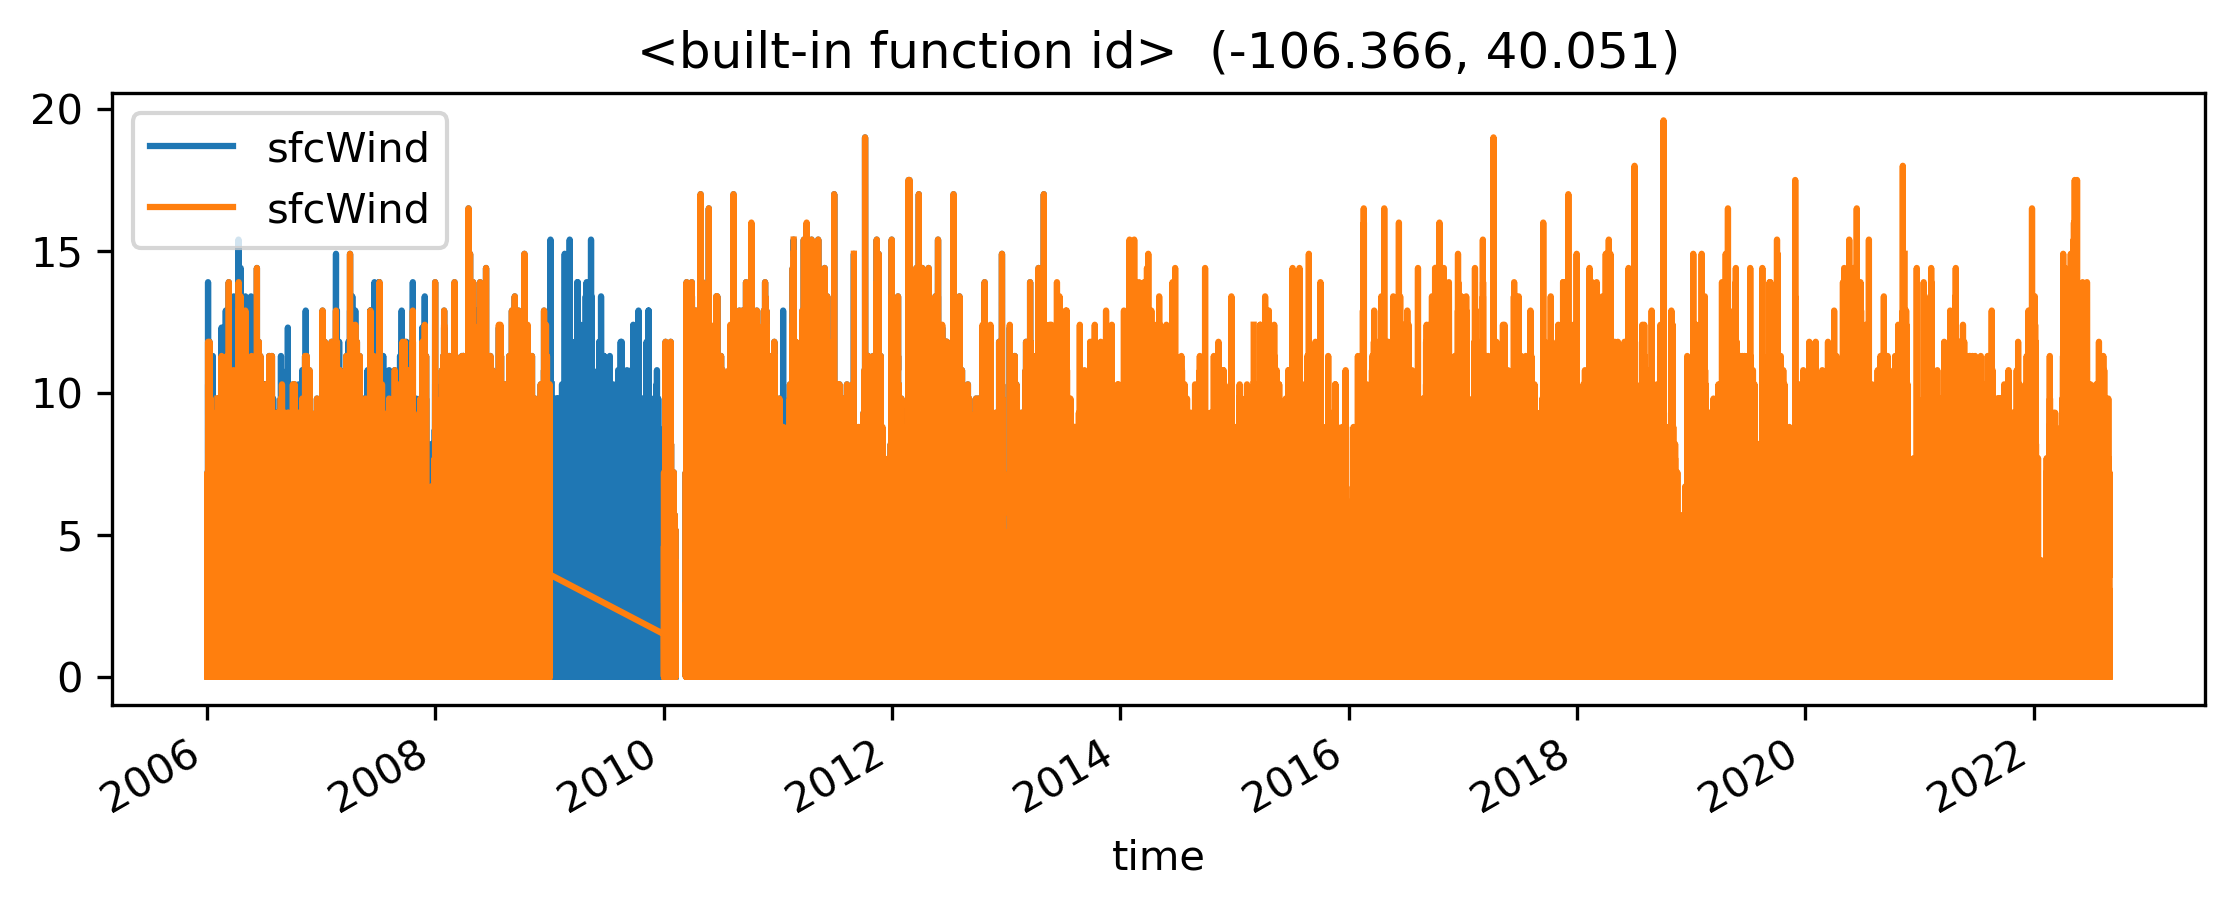

In [126]:
lon = df_1.lon.mean()
lat = df_1.lat.mean()
# print("{}, {:.5f}, {:.5f}".format(id, lon, lat))


# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

df_1.plot(ax=ax, x="time", y="sfcWind")
df_2.plot(ax=ax, x="time", y="sfcWind")

ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

In [ ]:
# when is the data identical?



## Final Function

In [ ]:
def matching_check(station_list):
    """
    Resamples meteorological variables to hourly timestep according to standard conventions.

    Rules
    ------
        1.) 

    Parameters
    ------
        df: pd.DataFrame
            list of station information

    Returns
    -------
        if success:
            list
                list of ICAO values of stations that need to be concatenated
        if failure:
            None
    """


    return None

## CODE SCRAPS

### Stations within a certain distance

In [8]:
# Convert the data into GeoDataFrames
# using EPSG 3310

gdf_asosawos = gpd.GeoDataFrame(asosawos_list, 
                        geometry=[Point(lon, lat) for lon, lat in zip(asosawos_list['LON'], asosawos_list['LAT'])],
                        crs="EPSG:4326").to_crs(epsg=3310)  

#### approach 3: find the nearest point in the geodataframe

In [9]:
# insert emtpy columns

gdf_asosawos['nearest_station'] = pd.Series(dtype='U16')
gdf_asosawos['distance'] = pd.Series(dtype='float32')


In [ ]:
for index, row in gdf_asosawos.iterrows():
    # geometry of individual row 
    point = row.geometry
    # returns a multipoint object with the geometries of every row in the gdf
    multipoint = gdf_asosawos.drop(index, axis=0).geometry.unary_union
    # 
    queried_geom, nearest_geom = nearest_points(point, multipoint)
    dist_from_point = 
    gdf_asosawos.loc[index, 'nearest_geometry'] = nearest_geom
    gdf_asosawos.loc[index, 'distance'] = nearest_geom

#### approach 2: distance function

In [20]:
## function to calculate the distance between points

def distance_sort_filter(row, df2, buffer=None, id=False):

    dist = df2.geometry.distance(row).sort_values()

    if buffer:
        dist = dist[dist<buffer]

    if id:
        distances = {df2.loc[idx]['WBAN']:value for idx,value in zip(dist.index, dist.values)}
    else:
        distances = {idx:value for idx,value in zip(dist.index, dist.values)}
    
    return distances

#### approach 1: using sjoin

In [13]:
# Create a buffer around points in gdf1 (e.g., 10 km buffer)
gdf_asosawos['buffer'] = gdf_asosawos.geometry.buffer(.1)  # Buffer in degrees, 0.1 degrees approx equals 10 km

In [ ]:
# Perform a spatial join using the buffer
merged = gpd.sjoin(gdf_asosawos, gdf_asosawos[['geometry', 'buffer']], how="inner", predicate="within")

# The 'merged' GeoDataFrame contains points from gdf_isd that are within the buffer around points in gdf_asosawos

In [ ]:
print(merged) # there are not ISD stations within 10km of an ASOSAWOS station missed by the exact matching

In [ ]:
### Round asosawos down to 3 decimal points of accuracy
# asosawos_round = asosawos_list.round({"LAT": 3, "LON": 3})